<a href="https://colab.research.google.com/github/indunil-19/ColabNotebooks-FYP/blob/main/Adapter_based_fine_tuning_without_trainer_42.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Training Single Task Adapters
For Bert SinBert and XLM-R Models

In [1]:
import torch
print("GPU Device name")
torch.cuda.get_device_name(0)

GPU Device name


'Tesla T4'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Parameters**

In [3]:
technique = "Sentiment"
experiment_no = "1"
oversample_dataset = False
over_sampling_technique = "ROS"
sampling_strategy = "1:0.25:0.25"
validation_size = (1/9)
test_size = 0.1
split_random_state = 42
training_seed = 8 #@param [ 8, 42, 77]
NO_OUTPUT_LAYERS = 4
id2label={ 0: "Negative", 1: "Neutral", 2: "Positive", 3:"Conflict"}
tag_set = ["Positive", "Negative", "Neutral", "Conflict"]
script="Char-Script-1.0"


load_adapter = False #@param {type:"boolean"}
unfreeze_model = False #@param {type:"boolean"}
save_adapter = False #@param {type:"boolean"}
lang_adapter_setting = "parallel" #@param ["none", "stack", "parallel"]
adapter_config = "houlsby" #@param ["houlsby", "pfeiffer"]

In [4]:
MAX_LEN = 128
BATCH_SIZE = 32
LEARNING_RATE = 5e-4
EPOCHS = 20

In [5]:
# technique="hate"
pretrained_adapter_path = "/content/drive/Shareddrives/Lingua/Final/"+technique #+ "_" + str(random_state)

### Installation

In [6]:
!pip install -U adapter-transformers==3.1.0
!pip install datasets
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 36.2 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.0
    Uninstalling tokenizers-0.15.0:
      Successfully uninstalled tokenizers-0.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
transformers 4.35.2 requires tokenizers<0.19,>=0.14, but you have tokenizers 0.12.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.4 MB/s eta 0:00:00


### Dependencies

In [7]:
import re
import time
# import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from google.colab import drive
from tqdm import tqdm
from sklearn.metrics import classification_report
import io
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from transformers import AutoAdapterModel ,AutoTokenizer, AdapterConfig,AutoConfig, AutoModelWithHeads, TrainingArguments, EvalPrediction, AdamW, get_scheduler, TextClassificationPipeline, EarlyStoppingCallback,set_seed
from transformers import  AdamW, get_linear_schedule_with_warmup,set_seed
from transformers.adapters.composition import Fuse, Stack, Parallel
from datasets import load_metric
from collections import Counter
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE
import matplotlib.pyplot as plt
%matplotlib inline


### Dataset Preprocessing

In [8]:
def apply_oversampling(x, y):

  (unique, counts) = np.unique(y, axis=0, return_counts=True)
  print("Class Distribution Without Oversampling", counts)

  # define oversampling strategy
  if (over_sampling_technique == ""):
    return x, y
  elif (over_sampling_technique == "ROS"):
    if (technique=="humor"):
      oversample = RandomOverSampler(sampling_strategy = float(sampling_strategy))
    else:
      sampling_ratio = sampling_strategy.split(":");
      oversample = RandomOverSampler(sampling_strategy = {
          0:int(counts[0]*float(sampling_ratio[0])),
          1:int(counts[0]*float(sampling_ratio[1])),
          2:int(counts[0]*float(sampling_ratio[2]))
          })
  elif (over_sampling_technique == "ADASYN"):
    oversample = ADASYN(sampling_strategy="minority")
  elif (over_sampling_technique == "SMOTE"):
    oversample = SMOTE()
  elif (over_sampling_technique == "BorderlineSMOTE"):
    oversample = BorderlineSMOTE()

  # fit and apply the transform
  X_over, y_over = oversample.fit_resample(x, y)

  (unique, counts) = np.unique(y_over, axis=0, return_counts=True)
  print("Class Distribution After Oversampling", counts)

  return X_over, y_over

In [9]:
dataset_path = "/content/drive/Shareddrives/Lingua/Sinhala-English CMCS Dataset/annotated-script(all).csv"
model_save_path = "/kaggle/working/"+technique+"/"+experiment_no

In [10]:
df = pd.read_csv(dataset_path)
df = df[['Sentence', technique, script]]
df.columns = ['Sentence', 'Label', script]

df['Label'], uniq = pd.factorize(df['Label'])

X, y = df[['Sentence', script]], df[['Label']]
stratifying_col = y["Label"]
X_rem, X_test, y_rem, y_test = train_test_split(X, y, test_size=test_size, stratify=stratifying_col, random_state=split_random_state)
stratifying_col = y_rem["Label"]
X_train, X_validation, y_train, y_validation = train_test_split(X_rem, y_rem, test_size=validation_size, stratify=stratifying_col, random_state=split_random_state)

In [11]:
del df, X, y, stratifying_col, X_rem, y_rem

In [12]:
uniq

Index(['Negative', 'Neutral', 'Positive', 'Conflict'], dtype='object')

In [13]:
print("X_train : Rows =", X_train.shape[0], ", Columns = ", X_train.shape[1])
print("y_train : Rows =", y_train.shape[0], ", Columns = ", y_train.shape[1])
print("X_validation : Rows =", X_validation.shape[0], ", Columns = ", X_validation.shape[1])
print("y_validation : Rows =", y_validation.shape[0], ", Columns = ", y_validation.shape[1])
print("X_test : Rows =", X_test.shape[0], ", Columns = ", X_test.shape[1])
print("y_test : Rows =", y_test.shape[0], ", Columns = ", y_test.shape[1])

X_train : Rows = 10814 , Columns =  2
y_train : Rows = 10814 , Columns =  1
X_validation : Rows = 1352 , Columns =  2
y_validation : Rows = 1352 , Columns =  1
X_test : Rows = 1352 , Columns =  2
y_test : Rows = 1352 , Columns =  1


In [14]:
print("Labels :", ['Negative', 'Neutral', 'Positive', 'Conflict'])
print("Train :", y_train.groupby('Label').size().tolist())
print("Validation :", y_validation.groupby('Label').size().tolist())
print("Test :", y_test.groupby('Label').size().tolist())

Labels : ['Negative', 'Neutral', 'Positive', 'Conflict']
Train : [2913, 6877, 924, 100]
Validation : [364, 860, 116, 12]
Test : [364, 860, 116, 12]


In [15]:
if oversample_dataset:
  X_train = np.array(X_train).reshape(-1, 1)
  X_train, y_train = apply_oversampling(X_train, y_train)
  X_train = [x[0] for x in X_train.tolist()]
# y_train = y_train.tolist()

##### **Preprocess Data**

In [16]:
set_seed(training_seed)

In [17]:
X_train, y_train = X_train.values.tolist(), y_train.values.tolist()
X_validation, y_validation = X_validation.values.tolist(), y_validation.values.tolist()
X_test, y_test = X_test.values.tolist(), y_test.values.tolist()

In [18]:
X_train_arr=[]
y_train_arr=[]

for i in range(len(X_train)):
    X_train_arr.append(X_train[i][0])
    y_train_arr.append(y_train[i][0])


X_validation_arr=[]
y_validation_arr=[]
for i in range(len(X_validation)):
    X_validation_arr.append(X_validation[i][0])
    y_validation_arr.append(y_validation[i][0])


X_test_arr=[]
y_test_arr=[]
X_test_latin=[]
y_test_latin=[]

X_test_Sinhala=[]
y_test_Sinhala=[]

X_test_Mixed=[]
y_test_Mixed=[]
for i in range(len(X_test)):
    X_test_arr.append(X_test[i][0])
    y_test_arr.append(y_test[i][0])

    if X_test[i][1]=="Latin":
        X_test_latin.append(X_test[i][0])
        y_test_latin.append(y_test[i][0])

    elif X_test[i][1]=="Sinhala":
        X_test_Sinhala.append(X_test[i][0])
        y_test_Sinhala.append(y_test[i][0])

    elif X_test[i][1]=="Mixed":
        X_test_Mixed.append(X_test[i][0])
        y_test_Mixed.append(y_test[i][0])

In [19]:
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base", do_lower_case=True)

In [20]:
encoded_X_train = tokenizer(X_train_arr, truncation=True, padding=True, max_length=MAX_LEN)
encoded_X_validation = tokenizer(X_validation_arr, truncation=True, padding=True, max_length=MAX_LEN)
encoded_X_test = tokenizer(X_test_arr, truncation=True, padding=True, max_length=MAX_LEN)
encoded_X_test_latin = tokenizer(X_test_latin, truncation=True, padding=True, max_length=MAX_LEN)
encoded_X_test_Sinhala = tokenizer(X_test_Sinhala, truncation=True, padding=True, max_length=MAX_LEN)
encoded_X_test_Mixed = tokenizer(X_test_Mixed, truncation=True, padding=True, max_length=MAX_LEN)



In [21]:
class DatasetObject(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = DatasetObject(encoded_X_train, y_train_arr)
validation_dataset = DatasetObject(encoded_X_validation, y_validation_arr)
test_dataset = DatasetObject(encoded_X_test, y_test_arr)
test_dataset_latin = DatasetObject(encoded_X_test_latin, y_test_latin)
test_dataset_Sinhala = DatasetObject(encoded_X_test_Sinhala, y_test_Sinhala)
test_dataset_Mixed = DatasetObject(encoded_X_test_Mixed, y_test_Mixed)


In [22]:
# train_sampler = RandomSampler(train_dataset)
train_sampler = SequentialSampler(train_dataset)
validation_sampler = SequentialSampler(validation_dataset)
test_sampler = SequentialSampler(test_dataset)
validation_sampler_latin = SequentialSampler(test_dataset_latin)
validation_sampler_sinhala= SequentialSampler(test_dataset_Sinhala)
validation_sampler_mixed = SequentialSampler(test_dataset_Mixed)

train_loader = DataLoader(train_dataset, sampler=train_sampler , batch_size=BATCH_SIZE)
validation_loader = DataLoader(validation_dataset, sampler=validation_sampler , batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, sampler=test_sampler , batch_size=BATCH_SIZE)
test_loader_latin = DataLoader(test_dataset_latin, sampler=validation_sampler_latin , batch_size=BATCH_SIZE)
test_loader_Sinhala = DataLoader(test_dataset_Sinhala, sampler=validation_sampler_sinhala , batch_size=BATCH_SIZE)
test_loader_Mixed = DataLoader(test_dataset_Mixed, sampler=validation_sampler_mixed , batch_size=BATCH_SIZE)

### Training

In [23]:
config = AutoConfig.from_pretrained("xlm-roberta-base", num_labels=NO_OUTPUT_LAYERS)
model = AutoModelWithHeads.from_pretrained("xlm-roberta-base", config=config)

/usr/local/lib/python3.10/dist-packages/transformers/adapters/models/roberta/adapter_model.py:255: FutureWarning: This class has been renamed to `RobertaModelWithHeads` in v3. Please use the new class instead as this class might be removed in a future version.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/transformers/adapters/models/roberta/adapter_model.py:233: FutureWarning: This class has been renamed to `RobertaModelWithHeads` in v3. Please use the new class instead as this class might be removed in a future version.
  warnings.warn(
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModelWithHeads: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaModelWithHeads from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModelWithHeads from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceCl

In [24]:
# Load an adapter
if load_adapter:
  print("loading adapter from", pretrained_adapter_path)
  model.load_adapter(pretrained_adapter_path, with_head=False)

# Add a new adapter
else:
  print("adding new adapter", adapter_config)
  if adapter_config == "pfeiffer":
    config = AdapterConfig.load("pfeiffer", reduction_factor=12)
  else:
    config = AdapterConfig.load("houlsby")
  model.add_adapter("task_"+technique, config=config)

adding new adapter houlsby


In [25]:
# Add a classification head
model.add_classification_head(
  "task_"+technique,
  num_labels=NO_OUTPUT_LAYERS,
  id2label=id2label
)

# Without Language Adapters
if lang_adapter_setting == "none":
  model.set_active_adapters("task_"+technique)

else:
  # Load language adapters
  lang_adapter_config = AdapterConfig.load("pfeiffer+inv")
  model.load_adapter("/content/drive/Shareddrives/Lingua/adapters/lan/mlm", config=lang_adapter_config, load_as="si-en", with_head=False)
  # model.load_adapter("/content/drive/Shareddrives/FYP/TrainedAdapters/si_mlm", config=lang_adapter_config, load_as="si", with_head=False)
  model.load_adapter("/content/drive/Shareddrives/Lingua/adapters/lan/si_mlm", config=lang_adapter_config, load_as="si", with_head=False)
  config = AdapterConfig.load("pfeiffer", non_linearity="relu", reduction_factor=2)
  model.load_adapter("en/wiki@ukp", config=config)

  # Stack Language Adapters
  if lang_adapter_setting == "stack":
    print("stacking language adapters")
    model.set_active_adapters(Stack("en", "si", "si-en", "task_"+technique))

  # Parallel Language Adapters
  else:
    print("stacking parallel language adapters set")
    model.set_active_adapters(Stack(Parallel("en", "si", "si-en"), "task_"+technique))

# Train Adapter
model.train_adapter("task_"+technique)

stacking parallel language adapters set


In [26]:
# Unfreeze the model to train both the model and adapter
if unfreeze_model:
  model.freeze_model(False)

In [27]:
model.cuda()
print("Done")

Done


In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [29]:
set_seed(training_seed)

In [30]:
def compute_metrics(allpreds,alllabels):
    metric1 = load_metric("precision")
    metric2 = load_metric("recall")
    metric3 = load_metric("f1")
    metric4 = load_metric("accuracy")

    predictions, labels = allpreds,alllabels
    precision = metric1.compute(predictions=predictions, references=labels, average="weighted")["precision"]
    recall = metric2.compute(predictions=predictions, references=labels, average="weighted")["recall"]
    f1 = metric3.compute(predictions=predictions, references=labels, average="weighted")["f1"]
    accuracy = metric4.compute(predictions=predictions, references=labels)["accuracy"]
    macro_precision = metric1.compute(predictions=predictions, references=labels, average="macro")["precision"]
    macro_recall = metric2.compute(predictions=predictions, references=labels, average="macro")["recall"]
    macro_f1 = metric3.compute(predictions=predictions, references=labels, average="macro")["f1"]
    return {"accuracy":accuracy, "precision": precision, "recall": recall, "f1": f1, "macro_precision": macro_precision, "macro_recall": macro_recall, "macro_f1": macro_f1}


In [31]:
def evaluate(model, dataloader):
    model.eval()
    allpreds = []
    alllabels = []

    for step, batch in enumerate(dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        logits = outputs.logits
        allpreds.extend(torch.argmax(logits, dim=-1))
        alllabels.extend(batch["labels"])
    return compute_metrics(allpreds,alllabels)

In [32]:
def calculate_loss_and_f1(model, dataloader):
    model.eval()
    allpreds = []
    alllabels = []
    total_loss = 0

    for step, batch in enumerate(dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        logits = outputs.logits
        loss = outputs.loss
        total_loss += loss.item()
        allpreds.extend(torch.argmax(logits, dim=-1))
        alllabels.extend(batch["labels"])

    macro_f1 = load_metric("f1").compute(predictions=allpreds, references=alllabels, average="macro")["f1"]
    return macro_f1, (total_loss/len(dataloader))

In [33]:
no_decay = ['bias', 'LayerNorm.weight']
num_training_steps = EPOCHS * len(train_loader)
betas = (0.9, 0.999)
eps = 1e-08
num_warmup_steps = 0
param_optimizer = list(model.named_parameters())

optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=LEARNING_RATE,betas=betas,eps=eps)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [34]:
tot_loss = 0
log_loss = 0
best_val_acc = 0

tot_train_time = 0
pbar_update_freq = 10

glb_step = 0
actual_step = 0
max_grad_norm = 1.0
eval_every_steps = 100
gradient_accumulation_steps = 1

leave_training = False
val_metric = "macro_f1"

best_epoch = -1
early_stop_epoch_thresh = 5

epoch_traces = []
acc_traces = []
validation_loss_traces = []

In [35]:
pbar = tqdm(total=num_training_steps, desc="Train")
for epoch in range(EPOCHS):
    print(f"Begin Epoch {epoch}")
    epoch_start_time = time.time()
    for step, batch in enumerate(train_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss = loss / gradient_accumulation_steps
        loss.backward()
        tot_loss += loss.item()
        actual_step += 1

        if actual_step % gradient_accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            glb_step += 1

            if glb_step % pbar_update_freq == 0:
                aveloss = (tot_loss - log_loss)/pbar_update_freq
                pbar.update(pbar_update_freq)
                pbar.set_postfix({'Average Loss': aveloss, "Epoch": epoch})
                log_loss = tot_loss

            if optimizer is not None:
                optimizer.step()
                optimizer.zero_grad()
            if scheduler is not None:
                scheduler.step()

        if glb_step > num_training_steps:
            leave_training = True
            break

    val_acc, val_loss = calculate_loss_and_f1(model, validation_loader)
    epoch_traces.append(epoch)
    acc_traces.append(val_acc)
    validation_loss_traces.append(val_loss)
    print("Validation: [Epoch: {}, Macro F1: {}, Validation Loss: {}, Time per Epoch: {}]".format(epoch, val_acc, val_loss, time.time()-epoch_start_time), flush=True)

    if val_acc > best_val_acc:
        torch.save(model.state_dict(),f"best_model.ckpt")
        best_val_acc = val_acc
        best_epoch = epoch

    elif (epoch - best_epoch) >= early_stop_epoch_thresh:
        print("Training stopped early at Epoch: %d" % epoch)
        break  # Terminate the training loop

    if leave_training:
        break

Train:   0%|          | 0/6760 [00:00<?, ?it/s]

Begin Epoch 0


Train:   5%|▍         | 330/6760 [02:25<47:43,  2.25it/s, Average Loss=0.595, Epoch=0]<ipython-input-32-0d8824a99c2b>:17: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  macro_f1 = load_metric("f1").compute(predictions=allpreds, references=alllabels, average="macro")["f1"]


Validation: [Epoch: 0, Macro F1: 0.48355027591726696, Validation Loss: 0.7124121161394341, Time per Epoch: 158.54995894432068]
Begin Epoch 1


Train:  10%|▉         | 670/6760 [05:04<42:54,  2.37it/s, Average Loss=0.512, Epoch=1]

Validation: [Epoch: 1, Macro F1: 0.5372296871962813, Validation Loss: 0.6468141986880191, Time per Epoch: 152.12265133857727]
Begin Epoch 2


Train:  15%|█▍        | 1010/6760 [07:42<40:33,  2.36it/s, Average Loss=0.338, Epoch=2]

Validation: [Epoch: 2, Macro F1: 0.5189163222354812, Validation Loss: 0.7528873439445052, Time per Epoch: 152.09309720993042]
Begin Epoch 3


Train:  20%|█▉        | 1350/6760 [10:15<38:00,  2.37it/s, Average Loss=0.232, Epoch=3]

Validation: [Epoch: 3, Macro F1: 0.5065715909439121, Validation Loss: 0.8738148565902266, Time per Epoch: 151.80566453933716]
Begin Epoch 4


Train:  25%|██▌       | 1690/6760 [12:48<35:27,  2.38it/s, Average Loss=0.218, Epoch=4]

Validation: [Epoch: 4, Macro F1: 0.4956919519504223, Validation Loss: 1.0905461713325146, Time per Epoch: 151.6758770942688]
Begin Epoch 5


Train:  30%|██▉       | 2020/6760 [15:16<33:19,  2.37it/s, Average Loss=0.0915, Epoch=5]

Validation: [Epoch: 5, Macro F1: 0.5087000477188592, Validation Loss: 1.0415455248466758, Time per Epoch: 151.71705961227417]
Begin Epoch 6


Train:  35%|███▍      | 2360/6760 [17:49<30:58,  2.37it/s, Average Loss=0.0942, Epoch=6]

Validation: [Epoch: 6, Macro F1: 0.5054988926827639, Validation Loss: 1.1177508200323858, Time per Epoch: 151.81223320960999]
Training stopped early at Epoch: 6


In [36]:
model.load_state_dict(torch.load(f"best_model.ckpt"))
model.cuda()
print("Done")

Done


In [37]:
evaluate(model, validation_loader)

{'accuracy': 0.7603550295857988,
 'precision': 0.7580399623582784,
 'recall': 0.7603550295857988,
 'f1': 0.7560771996862146,
 'macro_precision': 0.6387446909825427,
 'macro_recall': 0.5174102828473318,
 'macro_f1': 0.5372296871962813}

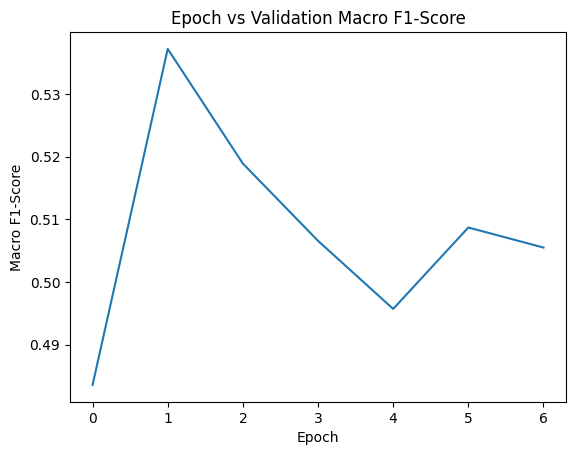

In [38]:
plt.plot(range(len(epoch_traces)), acc_traces)
plt.xlabel('Epoch')
plt.ylabel('Macro F1-Score')
plt.title('Epoch vs Validation Macro F1-Score')
plt.xticks(range(len(epoch_traces)), epoch_traces)
plt.show()

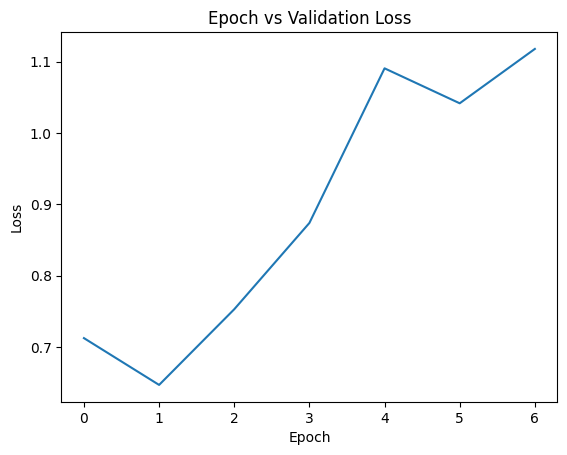

In [39]:
plt.plot(range(len(epoch_traces)), validation_loss_traces)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Validation Loss')
plt.xticks(range(len(epoch_traces)), epoch_traces)
plt.show()

In [40]:
evaluate(model, test_loader)

{'accuracy': 0.7928994082840237,
 'precision': 0.7888432722969364,
 'recall': 0.7928994082840237,
 'f1': 0.7898111689576169,
 'macro_precision': 0.5546917372174704,
 'macro_recall': 0.547576160807917,
 'macro_f1': 0.5495203345609001}

In [41]:
evaluate(model, test_loader_latin)

{'accuracy': 0.7921810699588477,
 'precision': 0.7873391175317689,
 'recall': 0.7921810699588477,
 'f1': 0.7893298012493032,
 'macro_precision': 0.5453357389114164,
 'macro_recall': 0.538955448904783,
 'macro_f1': 0.5413471299372462}

In [42]:
evaluate(model, test_loader_Sinhala)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 0.7771739130434783,
 'precision': 0.782140179910045,
 'recall': 0.7771739130434783,
 'f1': 0.7748476229175132,
 'macro_precision': 0.5971366995073892,
 'macro_recall': 0.5482568027210885,
 'macro_f1': 0.5637600133511349}

In [43]:
evaluate(model, test_loader_Mixed)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 0.8102564102564103,
 'precision': 0.8125303739165125,
 'recall': 0.8102564102564103,
 'f1': 0.8049760132340777,
 'macro_precision': 0.5567951438000943,
 'macro_recall': 0.5771812957157785,
 'macro_f1': 0.563010752688172}